In [1]:
import numpy as np
import os
import PIL
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="flower_photos", untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


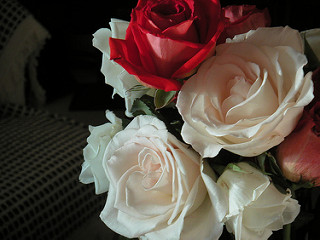

In [4]:
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[1]))

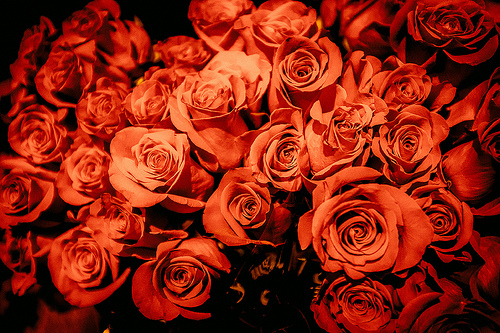

In [5]:
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[2]))

# Load using "tf.keras.preprocessing"

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


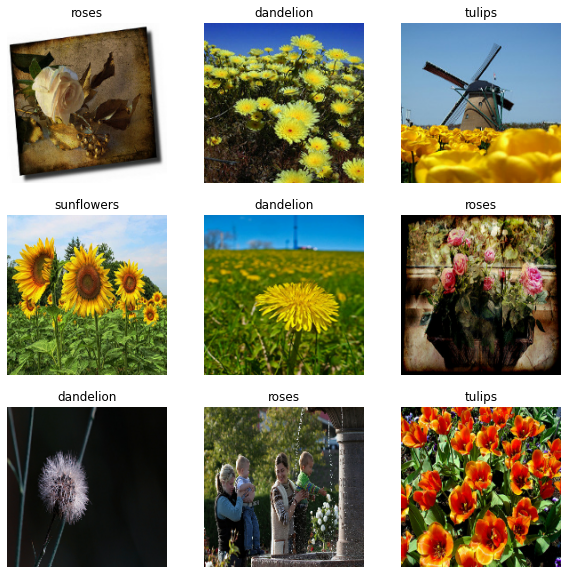

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer="adam", loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [17]:
model.fit(train_ds, validation_data=valid_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 7s 41ms/step - loss: 1.3425 - accuracy: 0.4244 - val_loss: 1.1227 - val_accuracy: 0.5668
Epoch 2/10
92/92 [==============================] - 2s 22ms/step - loss: 1.0700 - accuracy: 0.5773 - val_loss: 1.0453 - val_accuracy: 0.5586
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.9201 - accuracy: 0.6407 - val_loss: 1.0180 - val_accuracy: 0.6035
Epoch 4/10
92/92 [==============================] - 2s 21ms/step - loss: 0.7761 - accuracy: 0.7040 - val_loss: 0.9850 - val_accuracy: 0.6349
Epoch 5/10
92/92 [==============================] - 2s 21ms/step - loss: 0.5963 - accuracy: 0.7858 - val_loss: 1.0104 - val_accuracy: 0.6335
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4059 - accuracy: 0.8587 - val_loss: 1.0923 - val_accuracy: 0.6512
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.3802 - accuracy: 0.8634 - val_loss: 1.2912 - val_accuracy: 0.6403
Epoch 8/10
92

In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/"*/*"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [19]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\SB15\\.keras\\datasets\\flower_photos\\sunflowers\\16656015339_2ccb7cd18d.jpg'
b'C:\\Users\\SB15\\.keras\\datasets\\flower_photos\\sunflowers\\4933230161_12f3ee7587.jpg'
b'C:\\Users\\SB15\\.keras\\datasets\\flower_photos\\tulips\\19413898445_69344f9956_n.jpg'
b'C:\\Users\\SB15\\.keras\\datasets\\flower_photos\\roses\\6039330368_c30ed224c4_m.jpg'
b'C:\\Users\\SB15\\.keras\\datasets\\flower_photos\\dandelion\\10779476016_9130714dc0.jpg'


In [20]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [22]:
valid_size = int(image_count * 0.2)
train_ds = list_ds.skip(valid_size)
valid_ds = list_ds.take(valid_size)

In [23]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(valid_ds).numpy())

2936
734


In [24]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [25]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [26]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [27]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [28]:
for image, label in train_ds.take(1):
    print("Image Shape: " , image.numpy().shape)
    print("Label: ", label.numpy())

Image Shape:  (180, 180, 3)
Label:  2


In [29]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

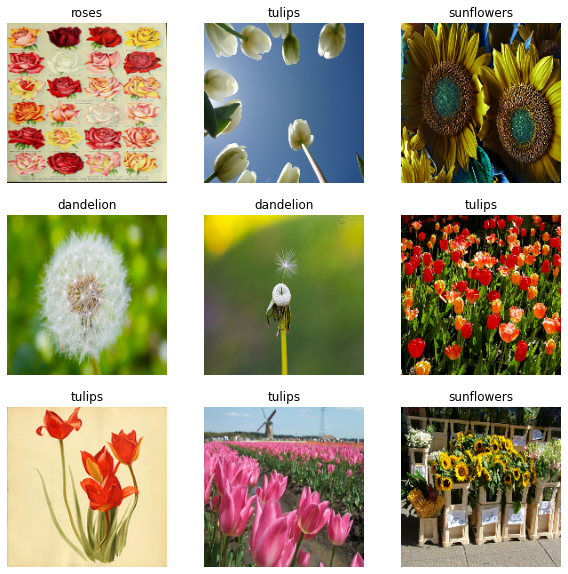

In [30]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [31]:
model.fit(train_ds, validation_data=valid_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 4s 36ms/step - loss: 0.3600 - accuracy: 0.9002 - val_loss: 0.3854 - val_accuracy: 0.8760
Epoch 2/10
92/92 [==============================] - 2s 27ms/step - loss: 0.1526 - accuracy: 0.9550 - val_loss: 0.3048 - val_accuracy: 0.9169
Epoch 3/10
92/92 [==============================] - 2s 26ms/step - loss: 0.0638 - accuracy: 0.9840 - val_loss: 0.3921 - val_accuracy: 0.8978
Epoch 4/10
92/92 [==============================] - 2s 25ms/step - loss: 0.0282 - accuracy: 0.9932 - val_loss: 0.4382 - val_accuracy: 0.8856
Epoch 5/10
92/92 [==============================] - 2s 25ms/step - loss: 0.0199 - accuracy: 0.9969 - val_loss: 0.4580 - val_accuracy: 0.8937
Epoch 6/10
92/92 [==============================] - 2s 24ms/step - loss: 0.0109 - accuracy: 0.9990 - val_loss: 0.3965 - val_accuracy: 0.9155
Epoch 7/10
92/92 [==============================] - 2s 25ms/step - loss: 0.0107 - accuracy: 0.9973 - val_loss: 0.4665 - val_accuracy: 0.9005
Epoch 8/10
92

# TensorFlow Dataset 사용

In [33]:
(train_ds, valid_ds, test_ds), meta_data = tfds.load(
    "tf_flowers", split=["train[:80%]", "train[80%:90%]", "train[90%:]"], with_info=True, as_supervised=True,
)

In [34]:
num_classes = meta_data.features["label"].num_classes
print(num_classes)

5


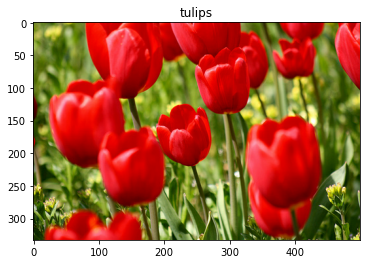

In [35]:
get_label_name = meta_data.features["label"].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [36]:
train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)
test_ds = configure_for_performance(test_ds)